In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error

import xgboost as xgb

In [312]:
file = open("../../data/features/2019_05_15_features_finally.pickle",'rb')
df = pickle.load(file, encoding='utf-8')
df[['Time']].head()

,Time
29,22:45:00
30,21:37:00
31,17:00:00
32,00:32:00
33,22:50:00


In [313]:
df.shape

(749, 28)

In [314]:
print(df.isnull().sum())
print(df.dtypes)

id                      0
Datetime                0
text                    0
sentiment               0
subjectivity            0
isreply                 0
year                    0
month                   0
day                     0
date                    0
DayofWeek               0
Weekend                 0
Time                    0
BinaryTrading           0
DayDistance             0
gtrend                  0
CommentSentimental      0
CommentSubjectivity     0
countComment            0
posCommentSum           0
negCommentSum           0
CommentSD               0
posCommentSD            0
negCommentSD            0
negCommentPercent       0
posCommentPercent       0
Volume_perc            29
Trading_Hour           29
dtype: int64
id                                  object
Datetime               datetime64[ns, UTC]
text                                object
sentiment                          float64
subjectivity                       float64
isreply                              int64
y

In [315]:
# drop one observation with NaN 'employer_yr_established'
# df = df[np.isfinite(df['That_hour_residual'])]
df = df.drop(['id','Datetime','text','date','Time'],1)
df.head()

,sentiment,subjectivity,isreply,year,month,day,DayofWeek,Weekend,BinaryTrading,DayDistance,...,countComment,posCommentSum,negCommentSum,CommentSD,posCommentSD,negCommentSD,negCommentPercent,posCommentPercent,Volume_perc,Trading_Hour
29,-0.025,0.225,0,2019,3,30,5,True,0,2,...,1635,181.046,-36.849,0.245,0.239,0.224,0.092,0.305,0.143,5.000
30,0.000,0.000,0,2019,3,30,5,True,0,2,...,998,115.902,-21.899,0.253,0.243,0.240,0.081,0.302,0.318,1.000
31,0.182,0.608,0,2019,3,30,5,True,0,2,...,321,44.391,-8.188,0.269,0.259,0.185,0.112,0.383,0.065,6.000
32,0.296,0.420,1,2019,3,30,5,True,0,2,...,490,60.349,-9.847,0.230,0.211,0.216,0.106,0.420,0.095,7.000
33,0.155,0.462,0,2019,3,29,4,False,0,3,...,359,40.492,-8.223,0.223,0.201,0.215,0.111,0.398,0.326,1.000


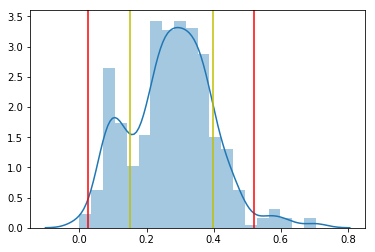

Volume_perc   0.151
dtype: float64

In [316]:
import seaborn as sns
sns.distplot(df[['Volume_perc']].dropna())
plt.axvline(0.52, 0,3, color='r')
plt.axvline(0.027, 0,3, color='r')
plt.axvline(0.397, 0,3, color='y')
plt.axvline(0.151, 0,3, color='y')
plt.show()
df[['Volume_perc']].mean() -1*df[['Volume_perc']].std()

In [319]:
bins = pd.IntervalIndex.from_tuples([(0, 0.397), (0.397, 0.52), (0.52, 1)])
vclass= pd.cut(list(df['Volume_perc']), bins)
vclass.categories =  ['0','1','2']
np.array(vclass)
df['vclass'] = vclass

In [320]:
# df['Time_Difference'].describe()

In [321]:
df.columns
df = df.dropna()

In [322]:
# prepare X and Y

X = df[['sentiment', 'subjectivity', 'isreply', 'year', 'month', 'day',
       'DayofWeek', 'Weekend',  'BinaryTrading', 'DayDistance',
       'gtrend', 'CommentSentimental', 'CommentSubjectivity',
       'posCommentSum', 'negCommentSum', 'CommentSD', 'posCommentSD',
       'negCommentSD', 'negCommentPercent', 'posCommentPercent', 'Volume_perc',
       'Trading_Hour']]

Y = df[['vclass']]

In [339]:
num_features = len(X.columns)

from sklearn.metrics import confusion_matrix
def cmatrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred, labels=['0', '1', '2'])
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [368]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y,  test_size=0.10, random_state=100)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

print(Y_train.vclass.value_counts()/Y_train.count()[0])
print(Y_test.vclass.value_counts()/Y_test.count()[0])



(642, 22) (642, 1)
(72, 22) (72, 1)
0   0.868
1   0.104
2   0.028
Name: vclass, dtype: float64
0   0.861
1   0.111
2   0.028
Name: vclass, dtype: float64


### 1. Linear Regression

In [326]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, Y_train)

print("Linear Reg R^2 training is: {}".format(linear_reg.score(X_train, Y_train)))
print("Linear Reg R^2 test data is: {}".format(linear_reg.score(X_test, Y_test)))
print("Linear Reg Train RMSE is: {}".format(np.sqrt(mean_squared_error(Y_train, linear_reg.predict(X_train)))))
print("Linear Reg Test RMSE is: {}".format(np.sqrt(mean_squared_error(Y_test, linear_reg.predict(X_test)))))


Linear Reg R^2 training is: 0.6161468499825986
Linear Reg R^2 test data is: -0.6491948417505087
Linear Reg Train RMSE is: 0.2807285632710235
Linear Reg Test RMSE is: 0.29416292784193426


### 2a. Simple Random Forest

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Confusion matrix, without normalization
[[62  0  0]
 [ 0  8  0]
 [ 0  0  2]]


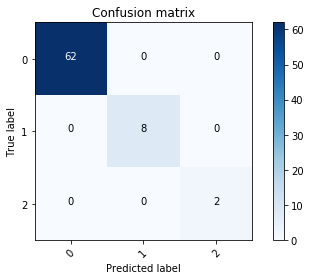

In [369]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)     # instantiate
random_forest.fit(X_train, Y_train)                         # fit

# print("Random Forest R^2 training is: {}".format(random_forest.score(X_train, Y_train)))                
# print("Linear Reg R^2 test data is: {}".format(random_forest.score(X_test, Y_test)))

# print("Random Forest Train RMSE is: {}".format(np.sqrt(mean_squared_error(Y_train, random_forest.predict(X_train)))))
# print("Random Forest Test RMSE is: {}".format(np.sqrt(mean_squared_error(Y_test, random_forest.predict(X_test)))))



plot_confusion_matrix(
    cmatrix(Y_test, random_forest.predict(X_test))
    , classes=['0', '1', '2'],
                      title='Confusion matrix')

### 2b. Random Forest with Cross Validation

In [328]:
rf_cv = RandomForestRegressor(n_estimators=1000, max_depth=70, max_features=np.sqrt(num_features), random_state=10)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = [10, 20, 30]
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]

# create the hyperparameter grid
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth}

print(hyperparam_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': [10, 20, 30], 'max_depth': [10, 20, 30, 40, 50]}


In [29]:
rf_grid = GridSearchCV(estimator = rf_cv, 
                       param_grid = hyperparam_grid,
                       cv = 5,
                       verbose=2,
                       n_jobs = -1)

# fit the grid search model
rf_grid.fit(X_train, Y_train)



Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] max_depth=10, max_features=10, n_estimators=200 .................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=200 .................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   0.7s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   0.8s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   0.7s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   0.8s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   0.9s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   1.2s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   1.2s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   1.1s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   1.1s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   1.1s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   1.5s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   1.5s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   1.5s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   1.5s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   1.5s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=   1.8s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=   1.8s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=   1.9s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=   1.8s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=   1.9s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   0.6s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   0.6s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   0.6s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   0.6s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   0.6s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   1.2s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   1.2s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   1.2s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   1.2s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   1.2s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=   1.9s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=   1.8s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=   1.8s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=   1.8s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=   1.8s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=   2.4s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=   2.4s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=   2.4s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=   2.8s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=   2.4s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=   3.0s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=   3.0s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=   3.0s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=   3.0s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=   3.0s
[CV] max_depth=10, max_features=30, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: max_features must be in (0, n_features]

In [42]:
# use optimal hyperparameters
rf_cv = RandomForestRegressor(n_estimators=1550, max_depth=70, max_features=5, random_state=10)
rf_cv.fit(X_train, Y_train)                         # fit

print("Random Forest R^2 training is: {}".format(rf_cv.score(X_train, Y_train)))                

print("Random Forest Train RMSE is: {}".format(np.sqrt(mean_squared_error(Y_train, rf_cv.predict(X_train)))))
print("Random Forest Test RMSE is: {}".format(np.sqrt(mean_squared_error(Y_test, rf_cv.predict(X_test)))))

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest R^2 training is: 0.9038870019890987
Random Forest Train RMSE is: 460043.22630251385
Random Forest Test RMSE is: 1556395.2772794364


In [179]:
modellist = [linear_reg, rf_cv]
modelname = ['log','rf']  

boot = [20,50,100,500]
from sklearn.metrics import mean_absolute_error

bootstrap = pd.DataFrame(columns=['size','model','mean','sd','CI','LB','UB'])
err = pd.DataFrame(columns=['size','model','mse'])
for n in boot:
    errors   = np.zeros((n, len(modellist)))
    
    for b in range(0,n):
        for i,model in enumerate(modellist):
            index = np.random.choice(list(range(0,len(X_test))),len(X_test), replace=True)
            errors[b,i] = mean_absolute_error(Y_test.iloc[index], model.predict(X_test.iloc[index]))
            err = err.append(pd.DataFrame([{'size': n, 'model' : modelname[i],'mse' : errors[b,i]  }])) 
            
    bootstrapres = pd.DataFrame({'size': n, 'model' : modelname,'mean' : errors.mean(axis=0) ,'sd' : np.std(errors, axis=0)})
#     print(bootstrapres)
    bootstrapres['CI'] = [ 1.96* b[3] for _,b in bootstrapres.iterrows()]
    bootstrapres['LB'] = [b[2] - 1.96* b[3] for _,b in bootstrapres.iterrows()]
    bootstrapres['UB'] = [b[2] + 1.96* b[3] for _,b in bootstrapres.iterrows()]
    
    bootstrap = bootstrap.append(bootstrapres) 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


  size model        mean         sd         CI         LB          UB
0   20   log 1013458.111 184604.811 361825.430 651632.680 1375283.541
1   20    rf  872625.023 159908.250 313420.171 559204.852 1186045.194
0   50   log  927412.349 149390.318 292805.022 634607.327 1220217.371
1   50    rf  877363.482 180180.186 353153.165 524210.317 1230516.646
0  100   log  936902.883 158761.537 311172.613 625730.270 1248075.496
1  100    rf  885303.883 167808.133 328903.940 556399.942 1214207.823
0  500   log  935855.347 149253.335 292536.537 643318.810 1228391.884
1  500    rf  869789.388 162919.980 319323.162 550466.227 1189112.550


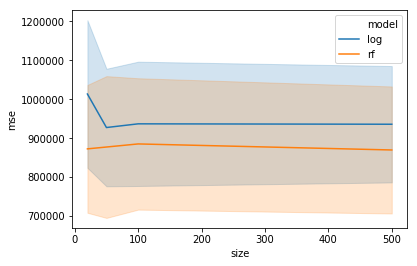

In [180]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(bootstrap)
import seaborn as sns
ax = sns.lineplot(x="size", y="mse",
             hue="model",ci='sd', 
             data=err)
# ax.fill_between(bootstrap.size, bootstrap.LB, bootstrap.UB, color='#888888', alpha=0.2)

plt.show()

1. Remove all unnecessary features and save df
2. Transform emoji to be processable
3. Remove NaN values